In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from pipeline.python.classifications import decode_by_ncells as dc
from pipeline.python.classifications import decode_utils as decutils
from pipeline.python.retinotopy import fit_2d_rfs as fitrf

from matplotlib.lines import Line2D
import matplotlib.patches as patches

In [2]:
%matplotlib notebook

In [3]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


# Dataset info

In [4]:
n_iterations=100
overlap_thr=None #0.5
n_processes=1
responsive_test='nstds'
experiment='blobs'
C_value=None

options=['-E', experiment, '-R', responsive_test, '-n', n_processes, '-N', n_iterations, '-o', overlap_thr, '-C', C_value]

opts = dc.extract_options(options)
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

# Set responsivitiy params
traceid = opts.traceid #'traces001'
response_type = opts.response_type #'dff'
responsive_test = opts.responsive_test #'nstds' # 'nstds' #'ROC' #None
responsive_thr = float(opts.responsive_thr) #10
n_stds = None if responsive_test=='ROC' else 2.5 #None
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 

# Create data ID for labeling figures with data-types
stim_filterby = None #'first'
has_gratings = experiment!='blobs'
g_str = 'hasgratings' if has_gratings else 'blobsonly'
filter_str = 'filter_%s_%s' % (stim_filterby, g_str)
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 
data_id = '|'.join([traceid, filter_str, response_str])
print(data_id)


# Choose what type classifier to make
m0=int(opts.class_a) #0
m100=int(opts.class_b) #106
n_iterations=int(opts.n_iterations) #100 
n_processes=int(opts.n_processes) #2
overlap_thr = None if opts.overlap_thr is None else float(opts.overlap_thr) 


# Set classifier training params
C_value = opts.C_value
do_cv = C_value is None
C_value = None if do_cv else float(opts.C_value)
print('Classify Morph %i v %i\nN=%i iterations (%i proc), overlap=%s, C=%s' \
      % (m0, m100, n_iterations, n_processes, str(overlap_thr), str(C_value)))


traces001|filter_None_blobsonly|dff_nstds-thr-10.00
Classify Morph 0 v 106
N=100 iterations (1 proc), overlap=None, C=None


In [5]:
train_str = 'by_singlecells_iter-%i' % (n_iterations)

# Set colors
visual_area, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


# Output dir

In [6]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

dst_dir = os.path.join(aggregate_dir, 'decoding', 'single_cells')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
    print(dst_dir)

# Get metadata for experiment type

In [8]:
#### Get metadata for experiment type
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
edata, expmeta = aggr.experiment_datakeys(sdata, experiment='blobs',
                                has_gratings=has_gratings, stim_filterby=stim_filterby)
   

In [11]:
 # Get blob metadata only - and only if have RFs
if overlap_thr is not None:
    dsets = pd.concat([g for k, g in edata.groupby(['animalid', 'session', 'fov']) if 
                        (experiment in g['experiment'].values 
                         and ('rfs' in g['experiment'].values or 'rfs10' in g['experiment'].values)) ])
else:
    dsets = pd.concat([g for k, g in edata.groupby(['animalid', 'session', 'fov']) if 
                        experiment in g['experiment'].values])
dsets[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

,datakey
visual_area,
Li,20
Lm,15
V1,11


In [19]:
reload(aggr)
reload(util)
reload(putils)

<module 'pipeline.python.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/utils.pyc'>

In [22]:
#### Check stimulus configs
stim_datakeys = dsets['datakey'].unique()
SDF, renamed_configs = aggr.check_sdfs(stim_datakeys, traceid=traceid, 
                                       images_only=False, return_incorrect=True)

*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15   0], y: [-5  0]


In [148]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

In [149]:
#### Load neural responses
trial_epoch= 'plushalf' #'stimulus'
responsive_test='nstds' #'roc'
responsive_thr=10 #10 #0.05
response_type='dff'

#### Check for equal trial counts
_, cells, MEANS, SDF = aggr.get_source_data(experiment, equalize_now=True, 
                                       response_type=response_type,
                                       responsive_test=responsive_test, 
                                       responsive_thr=responsive_thr, 
                                       trial_epoch=trial_epoch, check_configs=True, 
                                       zscore_now=True, return_configs=True ) 
cells.groupby(['visual_area']).count()
visual_areas = ['V1', 'Lm', 'Li', 'Ll']
cells = cells[cells['visual_area'].isin(visual_areas)]

sdf_master = aggr.get_master_sdf(images_only=True)


...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl
20190319_JC067_fov1: diff keys
20190316_JC070_fov1: diff keys
20190315_JC070_fov1: diff keys
20190327_JC073_fov1: diff keys
20190321_JC070_fov1: diff keys
20190322_JC073_fov1: diff keys
20190306_JC061_fov3: diff keys
20190320_JC067_fov1: diff keys
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15   0], y: [-5  0]
20190314_JC070_fov1: diff keys
---equalizing now---
Segmentation: missing 4 dsets


In [150]:
match_distns = False
match_str = 'match-Li-distn' if match_distns else ''
stack_neuraldf = match_distns==True

rfdf=None
if overlap_thr is not None:
    #### Load RF fits -------------------------------------
    rf_filter_by=None
    reliable_only = True
    rf_fit_thr = 0.5
    # -----------------------------------------------------
    rfdf = aggr.load_rfdf_and_pos(dsets, rf_filter_by=rf_filter_by, reliable_only=reliable_only, traceid=traceid)

    #### Final data
    NEURALDATA, RFDATA = aggr.get_neuraldata_and_rfdata(cells, rfdf, MEANS)
    
else:
    NEURALDATA = aggr.get_neuraldata(cells, MEANS, stack=stack_neuraldf)
    RFDATA=None

# BY fov

In [156]:
animalid = 'JC070'
session = '20190316'
fovnum=1
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
visual_area='Li'

In [157]:
sdf = SDF['20190316_JC070_fov1'].copy()
neuraldf = aggr.get_neuraldf_for_cells_in_area(cells, MEANS,
                                datakey=datakey, visual_area=visual_area)

In [173]:
# zscore full
neuraldf = aggr.zscore_neuraldf(neuraldf)
n_cells = int(neuraldf.shape[1]-1)
print("... [%s] %s, n=%i cells" % (visual_area, datakey, n_cells))

... [Li] 20190316_JC070_fov1, n=84 cells


In [177]:
# Decodinng -----------------------------------------------------
iter_list = decutils.fit_svm_mp(neuraldf, sdf, C_value=C_value,
                            n_iterations=50,
                            n_processes=1, verbose=False,
                            class_a=class_a, class_b=class_b, do_shuffle=True)

In [180]:
iter_results = pd.concat(iter_list, axis=0)

True: 0.60 (Shuffled; 0.48)


<IPython.core.display.Javascript object>


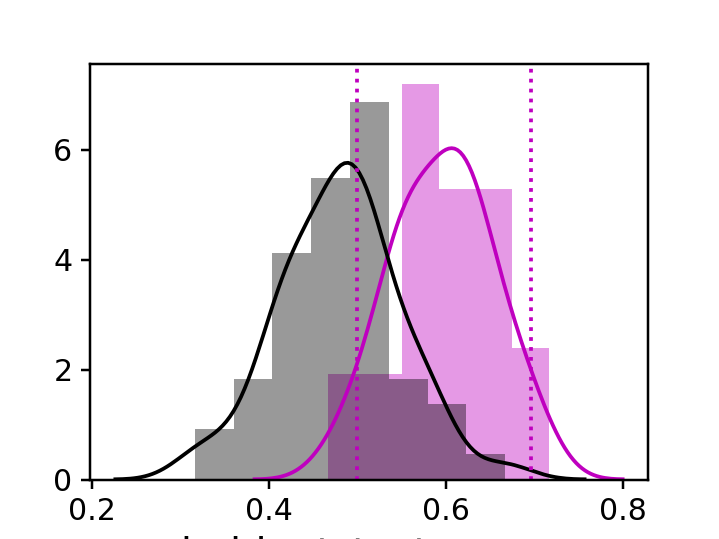

In [183]:
metric='heldout_test_score'
ci=0.95

tru_df = iter_results[iter_results['condition']=='data'].copy()
shu_df = iter_results[iter_results['condition']=='shuffled'].copy()

print('True: %.2f (Shuffled; %.2f)' % (tru_df[metric].mean(), shu_df[metric].mean()))

f, ax = pl.subplots(figsize=(4,3))
sns.distplot(tru_df[metric], color='m', label='data')
sns.distplot(shu_df[metric], color='k', label='shuffled')

ci_lo, ci_hi = putils.get_empirical_ci(tru_df[metric].values, ci=ci)
ax.axvline(x=ci_lo, linestyle=':', c='m')
ax.axvline(x=ci_hi, linestyle=':', c='m')

In [48]:
#### Combine into stacked df
NDATA = aggr.neuraldf_dict_to_dataframe(NEURALDATA)
NDATA[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

counts = NDATA[['visual_area', 'datakey', 'cell']]\
            .drop_duplicates().groupby(['visual_area', 'datakey']).count().reset_index()


<IPython.core.display.Javascript object>


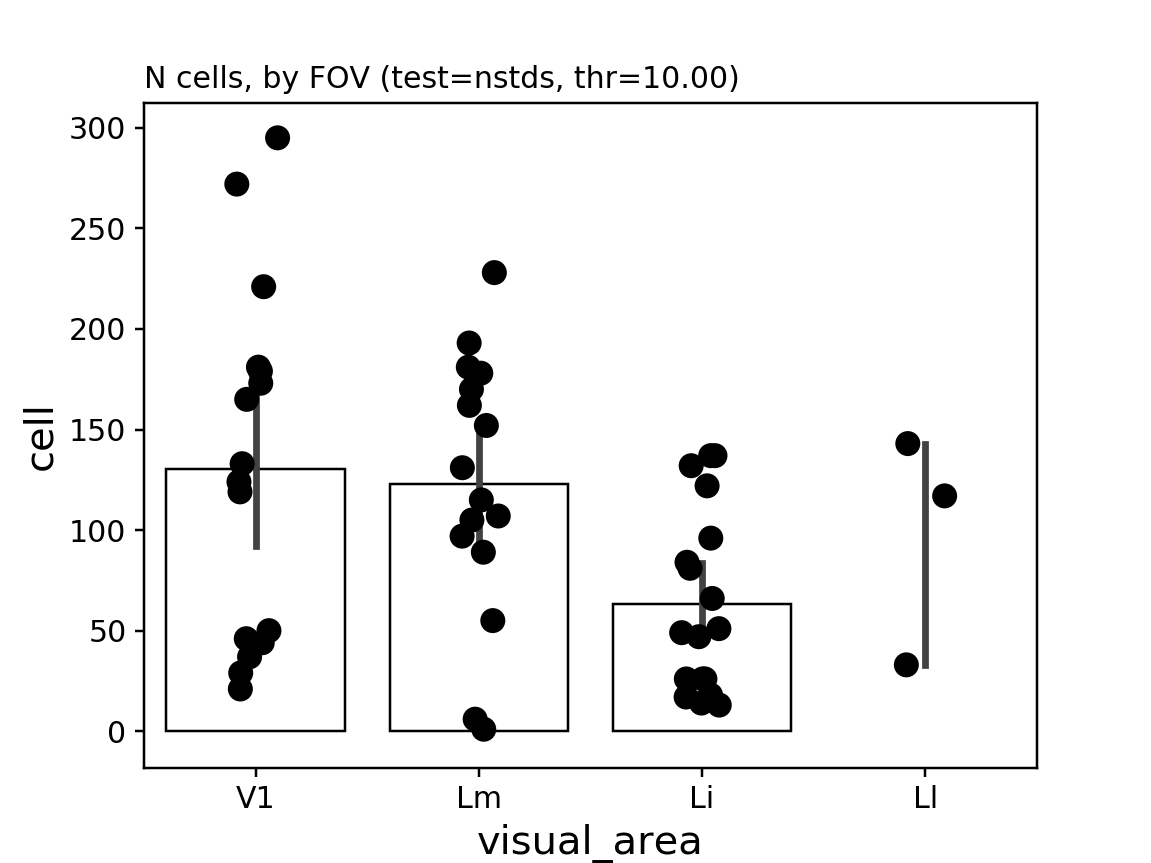

Text(0,1,u'N cells, by FOV (test=nstds, thr=10.00)')

In [49]:
fig, ax = pl.subplots()
# sns.barplot(x='visual_area', y='cell', data=counts, ax=ax,
#            hue='datakey', palette='colorblind')
# ax.legend_.remove()
sns.barplot(x='visual_area', y='cell', data=counts, ax=ax,
           facecolor='w', edgecolor=('k', 'k', 'k'), order=visual_areas)
sns.stripplot(x='visual_area', y='cell', data=counts, ax=ax,
            order=visual_areas, color='k', s=10)
ax.set_title("N cells, by FOV (test=%s, thr=%.2f)" % (responsive_test, responsive_thr), loc='left')
#counts

#### Get global cells

In [50]:
remove_too_few = True
min_ncells=5
# overlap_thr=0.5

####
if overlap_thr is not None:
    #### Calculate overlap with stimulus
    stim_overlaps = rfutils.calculate_overlaps(RFDATA, experiment=experiment)
    
    #### Get global-indexed cells
    globalcells, cell_counts = aggr.get_pooled_cells(stim_overlaps, 
                                        remove_too_few=remove_too_few,
                                        overlap_thr=overlap_thr, min_ncells=min_ncells,
                                        return_counts=True)
else:
    globalcells, cell_counts = aggr.global_cells(cells, remove_too_few=remove_too_few, 
                                        min_ncells=min_ncells, return_counts=True)
    

In [51]:
if overlap_thr is not None:
    pass_overlaps = stim_overlaps[stim_overlaps['perc_overlap']>=overlap_thr].copy()
    counts_by_dset = aggr.get_counts_by_datakey(pass_overlaps)
    
else:
    counts_by_dset = aggr.get_counts_by_datakey(cells)
counts_by_dset.groupby(['visual_area']).sum()

,n_cells,fovnum
visual_area,,
Li,1142,18
Ll,293,3
Lm,1970,18
V1,2089,16


In [52]:
cell_counts

{u'Li': 1142, u'Ll': 293, u'Lm': 1970, u'V1': 2089}

In [53]:
dst_dir


'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells'

<IPython.core.display.Javascript object>


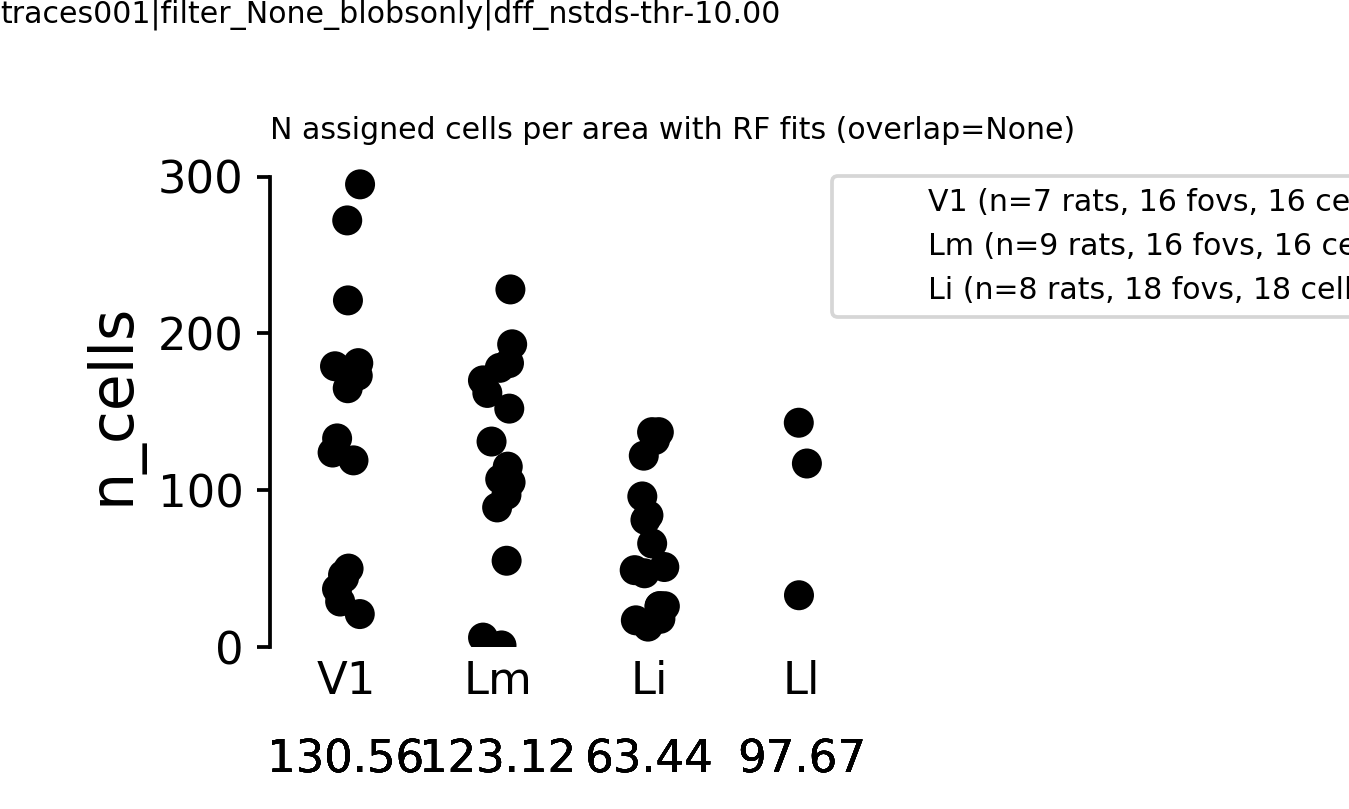

In [43]:
f, ax = pl.subplots(dpi=dpi, figsize=(5,3))
sns.stripplot(x='visual_area', y='n_cells', data=counts_by_dset, ax=ax,
             order=visual_areas, color='k', s=8, alpha=1)
sns.barplot(x='visual_area', y='n_cells', data=counts_by_dset, ax=ax,
             order=visual_areas, color='w', errcolor='w')
counts_by_dset.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -30))


ax.tick_params(which='both', axis='x', size=0)
ax.set_ylim([0, ax.get_ylim()[-1]])
sns.despine(bottom=True, trim=True, ax=ax)

ax.set_xlabel('')
pl.subplots_adjust(left=0.2, bottom=0.2, top=0.8)
ax.set_title("N assigned cells per area with RF fits (overlap=%s)" % str(overlap_thr), loc='left', fontsize=8)
putils.label_figure(f, data_id)

leg = aggr.get_counts_for_legend(counts_by_dset, markersize=0, lw=0)
ax.legend(handles=leg, bbox_to_anchor=(0.9,1), fontsize=8)
pl.subplots_adjust(left=0.2, right=0.65, bottom=0.2)

figname = 'ncells_assigned_with_rfs__%s-%s__%s' % (response_type, responsive_test, match_str)
#pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))


# Decode

In [54]:
test_split=0.2
cv_nfolds=5
C_value=None

class_a=0
class_b=106


#### Test boot

In [55]:
visual_area = 'V1'
datakey = '20190622_JC085_fov1'

# visual_area = 'Lm'
# datakey = '20190306_JC061_fov3'

curr_ncells = 1
sdf = SDF[datakey].copy()
gdf = globalcells[(globalcells['visual_area']==visual_area)
                 & (globalcells['datakey']==datakey)].copy() # globalcells for current visual_area

#rid = 2
#rid in gdf['dset_roi']
curr_rois = gdf['dset_roi'].unique()
print('%i cells found (%s, %s)' % (len(curr_rois), datakey, visual_area))

173 cells found (20190622_JC085_fov1, V1)


In [56]:
gdf.head()

,datakey,dset_roi,roi,visual_area,animalid,session,fovnum
0,20190622_JC085_fov1,10.0,1695,V1,JC085,20190622,1
1,20190622_JC085_fov1,11.0,1696,V1,JC085,20190622,1
2,20190622_JC085_fov1,12.0,1697,V1,JC085,20190622,1
3,20190622_JC085_fov1,13.0,1698,V1,JC085,20190622,1
4,20190622_JC085_fov1,14.0,1699,V1,JC085,20190622,1


#### Test boot iter for 1 cell

In [62]:
rid = 166
# rid in NEURALDATA[visual_area][datakey].columns

curr_data = NEURALDATA[visual_area][datakey][[rid, 'config']].copy()
print(curr_data.shape)
assert len(curr_data['config'].value_counts().unique())==1, "(%s) ERR: uneven trial counts by config" % datakey


(1500, 2)


<IPython.core.display.Javascript object>


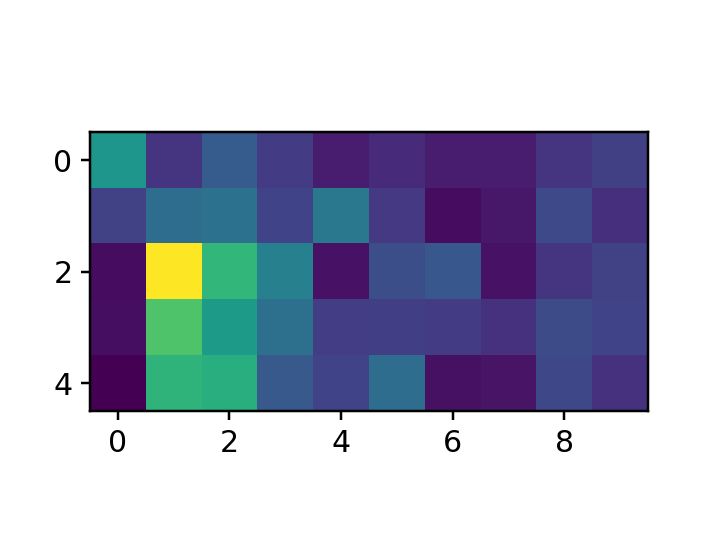

In [63]:
n_morphs = 10 #len(sdf['morphlevel'].unique())
stimmat = curr_data.groupby(['config']).mean().values.reshape((n_morphs, 5)).T
pl.figure(figsize=(4,3))
pl.imshow(stimmat)

## Run bootstrap for 1 cell

In [64]:
# n_iterations=50

# i_=[]; s_=[];
# for inum in np.arange(0, n_iterations):
#     it_df, sh_df = decutils.do_fit_within_fov(inum, curr_data=curr_data, sdf=sdf, return_shuffle=True,
#                                         C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds, 
#                                         class_a=class_a, class_b=class_b)
#     i_.append(it_df)
#     s_.append(sh_df)
    
# iterdf = pd.concat(i_, axis=0)
# shufdf = pd.concat(s_, axis=0)
# iterdf.mean()

In [69]:
i = decutils.fit_svm_mp(curr_data, sdf, C_value=None, 
                       n_iterations=50, n_processes=2,
                       verbose=False, class_a=0, class_b=106)
iterdf = pd.concat(i, axis=0)

True: 0.64 (Shuffled; 0.46)


<IPython.core.display.Javascript object>


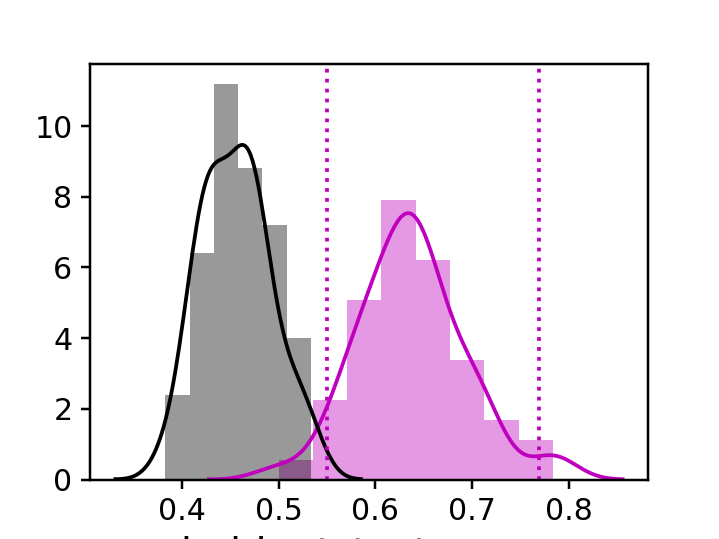

In [70]:
metric='heldout_test_score'
ci=0.95

tru_df = iterdf[iterdf['condition']=='data'].copy()
shu_df = iterdf[iterdf['condition']=='shuffled'].copy()

print('True: %.2f (Shuffled; %.2f)' % (tru_df[metric].mean(), shu_df[metric].mean()))

f, ax = pl.subplots(figsize=(4,3))
sns.distplot(tru_df[metric], color='m', label='data')
sns.distplot(shu_df[metric], color='k', label='shuffled')

ci_lo, ci_hi = putils.get_empirical_ci(tru_df[metric].values, ci=ci)
ax.axvline(x=ci_lo, linestyle=':', c='m')
ax.axvline(x=ci_hi, linestyle=':', c='m')

#### Cycle thru all cells in curr fov

In [71]:
rid in curr_rois[0::5]

True

In [72]:
d_list=[]
for ri, rid in enumerate(curr_rois[0::5]):
    #print('...%i of %i cells' % (int(ri+1), len(curr_rois)))
    curr_data = NEURALDATA[visual_area][datakey][[rid, 'config']].copy()
    i = decutils.fit_svm_mp(curr_data, sdf, C_value=None, 
                           n_iterations=50, n_processes=2,
                           verbose=False, class_a=0, class_b=106)
    
    iterdf = pd.concat(i, axis=0)
    meanscore = iterdf[iterdf['condition']=='data'][metric].mean()
    print('%i: %.2f' % (rid, meanscore))
#     i_=[]; s_=[];
#     for inum in np.arange(0, n_iterations):
#         it_df, sh_df = decutils.do_fit_within_fov(inum, curr_data=curr_data, sdf=sdf, return_shuffle=True,
#                                             C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds, 
#                                             class_a=class_a, class_b=class_b)
#         i_.append(it_df)
#         s_.append(sh_df)
#     iterdf = pd.concat(i_, axis=0)
#     shufdf = pd.concat(s_, axis=0)
#     iterdf['condition'] = 'data'
#     shufdf['conditon'] = 'shuffled'
#     df_ = pd.concat([iterdf, shufdf], axis=0)

    iterdf['rid'] = rid
    d_list.append(iterdf)
    
df = pd.concat(d_list, axis=0)
print(df.shape, iterdf.shape, df.shape)

10: 0.51
15: 0.55
24: 0.54
32: 0.45
38: 0.45
47: 0.66
62: 0.54
69: 0.45
79: 0.54
86: 0.46
94: 0.45
166: 0.65
171: 0.52
180: 0.45
201: 0.46
209: 0.52
215: 0.57
221: 0.47
227: 0.48
236: 0.52
243: 0.49
251: 0.50
259: 0.46
268: 0.61
279: 0.54
288: 0.45
295: 0.55
310: 0.46
318: 0.52
327: 0.58
340: 0.58
347: 0.53
355: 0.61
360: 0.53
378: 0.51


NameError: name 'df_' is not defined

In [87]:
len(df['rid'].unique())


35

<IPython.core.display.Javascript object>


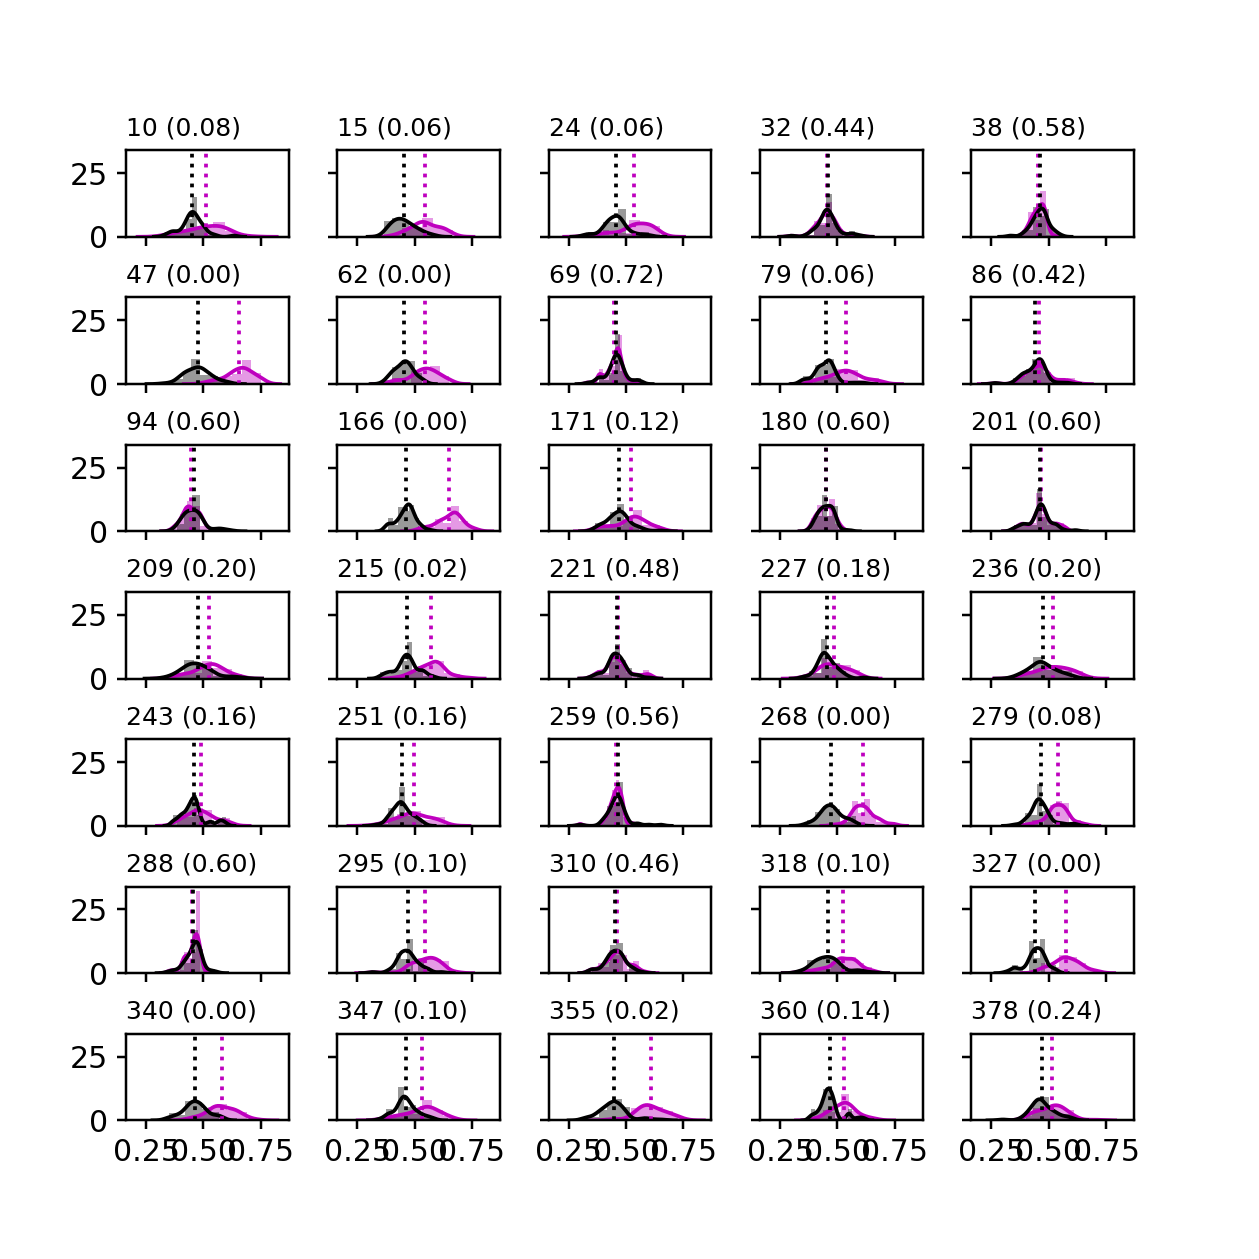

In [101]:
# xdf = df[df['rid']==166].copy()
# tru_df = xdf[xdf['condition']=='data'].copy()
# shu_df = xdf[xdf['condition']=='shuffled'].copy()

# print('True: %.2f' % tru_df[metric].median())
# print('Shuffled: %.2f' % shu_df[metric].median())

f, axn = pl.subplots(7, 5, figsize=(7,7), sharex=True, sharey=True)
for ax, (rid, xdf) in zip(axn.flat, df.groupby(['rid'])):
    tru_df = xdf[xdf['condition']=='data'].copy()
    shu_df = xdf[xdf['condition']=='shuffled'].copy()

    mean_score = tru_df[metric].mean()
    shuff_score = shu_df[metric].mean()
    
    score_percentile = np.mean(mean_score < shu_df[metric])
    #meandiff = tru_df[metric].mean() - shu_df[metric].mean()

    sns.distplot(tru_df[metric], color='m', label='data', ax=ax)
    sns.distplot(shu_df[metric], color='k', label='shuffled', ax=ax)
    ax.axvline(x=mean_score, linestyle=':', c='m')
    ax.axvline(x=shuff_score, linestyle=':', c='k')
    
    #ci_lo, ci_hi = putils.get_empirical_ci(tru_df[metric].values, ci=ci)
    #ax.axvline(x=ci_hi, linestyle=':', c='m')
    
    ax.set_title("%i (%.2f)" % (rid, score_percentile), loc='left', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
pl.subplots_adjust(wspace=0.3, hspace=0.7, left=0.1, right=0.9)

In [77]:
df.head()


,C,fit_time,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,score_time,test_score,train_score,condition,n_cells,n_trials,rid
25,1.0,0.000935,2.819068e-02,2.871288e-02,0.040671,0.616667,0.000332,0.545851,0.555215,data,1,300,10.0
25,1.0,0.000910,-4.440892e-16,-1.928242e-15,0.000000,0.466667,0.000301,0.499826,0.521805,shuffled,1,300,10.0
26,0.1,0.000798,3.786456e-03,-7.007129e-03,0.005463,0.550000,0.000307,0.566522,0.558280,data,1,300,10.0
26,0.1,0.000830,-4.440892e-16,-1.928242e-15,0.000000,0.466667,0.000301,0.504082,0.507297,shuffled,1,300,10.0
27,1.0,0.001014,2.792653e-04,-1.217920e-02,0.000403,0.500000,0.000332,0.587614,0.572946,data,1,300,10.0


In [84]:
meandf = df.groupby(['condition', 'rid']).mean().reset_index()


True: 0.52
Shuffled: 0.46


<IPython.core.display.Javascript object>


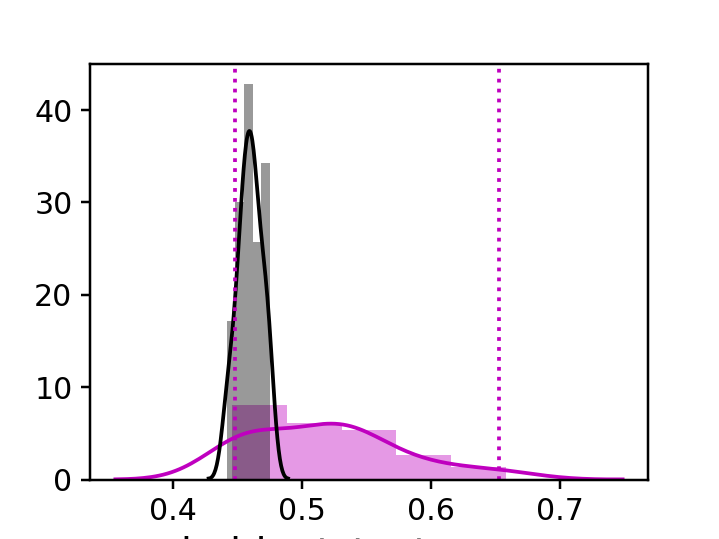

In [85]:
xdf = meandf.copy()
tru_df = xdf[xdf['condition']=='data'].copy()
shu_df = xdf[xdf['condition']=='shuffled'].copy()

print('True: %.2f' % tru_df[metric].median())
print('Shuffled: %.2f' % shu_df[metric].median())

f, ax = pl.subplots(figsize=(4,3))
sns.distplot(tru_df[metric], color='m', label='data')
sns.distplot(shu_df[metric], color='k', label='shuffled')

ci_lo, ci_hi = putils.get_empirical_ci(tru_df[metric].values, ci=ci)
ax.axvline(x=ci_lo, linestyle=':', c='m')
ax.axvline(x=ci_hi, linestyle=':', c='m')

# Aggregate single cell results for 1 FOV

In [ ]:
def check_old_naming(animalid, session, fov, experiment='blobs', traceid='traces001',
                decode_type='single_cells', sub_dir='dff-nstds_stimulus', C_str='tuneC',
                rootdir='/n/coxfs01/2p-data'):
    
    res_files = glob.glob(os.path.join(rootdir, animalid, session, fov, 
                            'combined_%s_static' % experiment, 'traces', '%s*' % traceid, 
                            'decoding', decode_type, sub_dir, '*%s*.pkl' % C_str))
    for r in res_files:
        curr_dir, fname = os.path.split(r)
        if fname.startswith('single_cells_'):
            new_name = fname.split('single_cells_')[-1]
            os.rename(r, os.path.join(curr_dir, new_name))
    return


In [217]:
def load_cell_results_from_fov(animalid, session, fov, experiment, traceid='traces001',
                               C_value=None, response_type='dff', responsive_test='nstds',
                               trial_epoch='stimulus', 
                               rootdir='/n/coxfs01/2p-data'):
    '''
    From running batch, slurm/decode_by_ncells.py (Set analysis_type='single_cells'),
    load all the cells' results.
    '''
    roidf=None
    sub_dir = '%s-%s_%s' % (response_type, responsive_test, trial_epoch)
    #print(sub_dir)
    C_str = 'tuneC' if C_value is None else 'C%.2f' % C_value
    check_old_naming(animalid, session, fov, experiment=experiment, traceid=traceid,
                     decode_type='single_cells', sub_dir=sub_dir, C_str=C_str)
    
    cell_results = glob.glob(os.path.join(rootdir, animalid, session, fov, 
                            'combined_%s_static' % experiment, 'traces', '%s*' % traceid, 
                            'decoding', 'single_cells', sub_dir, '*%s*.pkl' % C_str))
    rlist=[]
    for c in cell_results:
        with open(c, 'rb') as f:
            res = pkl.load(f)

        res['iteration'] = res.index.tolist()
        res = res.reset_index(drop=True).sort_values(by='iteration')
        rlist.append(res)
        
    if len(rlist)>0:
        #roidf = pd.concat(rlist, axis=1).T
        roidf = pd.concat(rlist, axis=0)
        
    return roidf


In [231]:
s ='single_cells_Li_tuneC_123.pkl'
s.split('single_cells_')

['', 'Li_tuneC_123.pkl']

In [200]:
rootdir='/n/coxfs01/2p-data'
traceid='traces001'
experiment='blobs'
# -----------------------------------------------------
response_type='dff'
responsive_test='nstds'
# -----------------------------------------------------


In [201]:
#datakey = '20190316_JC070_fov1'

animalid = 'JC070'
session = '20190316'
fovnum=1
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
visual_area='Li'
overlap_thr = None

trial_epoch = 'plushalf'

In [218]:
# visual_area = 'Li'
# animalid = 'JC091'
# session = '20190602'
# fovnum = 1
# fov = 'FOV%i_zoom2p0x' % fovnum
# datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

# curr_ncells = globalcells[(globalcells['datakey']==datakey) & (globalcells['visual_area']==visual_area)].shape
roidf = load_cell_results_from_fov(animalid, session, fov, experiment, traceid=traceid,
                                   C_value=None, trial_epoch=trial_epoch,
                                   response_type=response_type, responsive_test=responsive_test,
                                   rootdir=rootdir)
curr_ncells = roidf.shape[0]
metainfo = {'datakey': datakey, 'visual_area': visual_area}
roidf = putils.add_meta_to_df(roidf, metainfo)
print(roidf.shape)

(16800, 16)


In [222]:
means_by_cell = roidf.groupby(['cell', 'condition']).mean().reset_index()


<IPython.core.display.Javascript object>


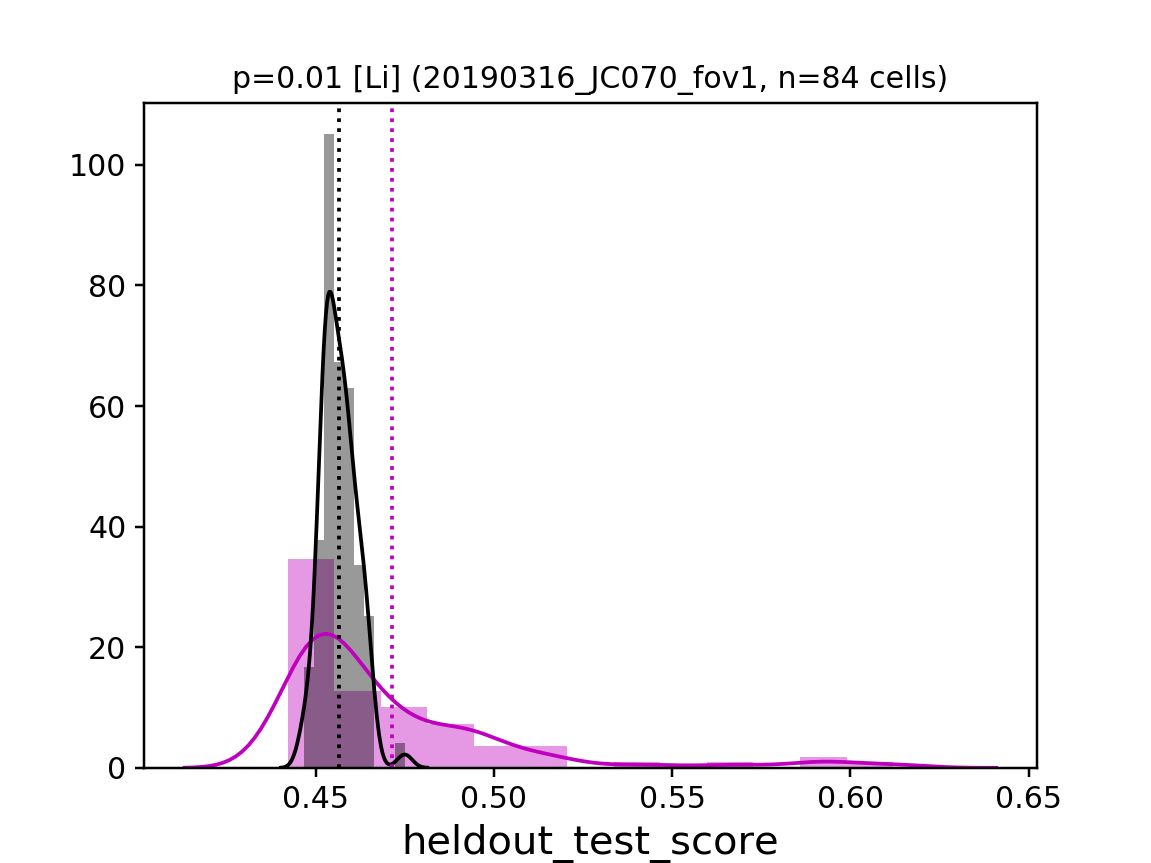

0.47, 0.46


Text(0.5,1,u'p=0.01 [Li] (20190316_JC070_fov1, n=84 cells)')

In [230]:
metric = 'heldout_test_score'

curr_ncells = len(means_by_cell['cell'].unique())
fig, ax = pl.subplots()

tru_df = means_by_cell[means_by_cell['condition']=='data']
shu_df = means_by_cell[means_by_cell['condition']=='shuffled']

mean_score = tru_df[metric].mean()
shuffled_score = shu_df[metric].mean()
score_percentile = np.mean(mean_score < shu_df[metric])
print('%.2f, %.2f' % (mean_score, shuffled_score))


sns.distplot(tru_df[metric], ax=ax, color='m')
sns.distplot(shu_df[metric], ax=ax, color='k')

ax.axvline(x=mean_score, linestyle=':', color='m')
ax.axvline(x=shuffled_score, linestyle=':', color='k')


ax.set_title("p=%.2f [%s] (%s, n=%i cells)" \
             % (score_percentile, visual_area, datakey, curr_ncells))

# Aggregate all single cell results

In [11]:
r_list=[]
for (visual_area, animalid, session, fovnum, datakey), g \
    in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey']):
    roidf = load_cell_results_from_fov(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                            experiment, C_value=None, trial_epoch=trial_epoch,
                            response_type=response_type, responsive_test=responsive_test,
                            rootdir=rootdir)
    
    if roidf is None:
        print("[%s] %s - No cells." % (visual_area, datakey))
        continue
    curr_ncells = roidf.shape[0]
    print("[%s] %s, n=%i cells" % (visual_area, datakey, curr_ncells))
    metainfo = {'datakey': datakey, 'visual_area': visual_area}
    roidf = putils.add_meta_to_df(roidf, metainfo)
    r_list.append(roidf)
singledf = pd.concat(r_list, axis=0)

[Li] 20190502_JC076_fov1 - No cells.
[Li] 20190605_JC090_fov1 - No cells.
[Li] 20190602_JC091_fov1, n=57 cells
[Li] 20190606_JC091_fov1, n=25 cells
[Li] 20190607_JC091_fov1, n=38 cells
[Li] 20190614_JC091_fov1, n=37 cells
[Li] 20191008_JC091_fov1 - No cells.
[Li] 20190609_JC099_fov1, n=20 cells
[Li] 20190612_JC099_fov1, n=7 cells
[Li] 20190617_JC099_fov1 - No cells.
[Li] 20191018_JC113_fov1 - No cells.
[Li] 20191105_JC117_fov1 - No cells.
[Li] 20191111_JC120_fov1 - No cells.
[Lm] 20190430_JC078_fov1, n=27 cells
[Lm] 20190504_JC078_fov1 - No cells.
[Lm] 20190509_JC078_fov1 - No cells.
[Lm] 20190513_JC078_fov1, n=16 cells
[Lm] 20190506_JC080_fov1, n=28 cells
[Lm] 20190603_JC080_fov1, n=48 cells
[Lm] 20190508_JC083_fov1 - No cells.
[Lm] 20190512_JC083_fov1 - No cells.
[Lm] 20190517_JC083_fov1 - No cells.
[Lm] 20190525_JC084_fov1, n=34 cells
[Lm] 20190627_JC091_fov1 - No cells.
[Lm] 20190618_JC097_fov1, n=25 cells
[V1] 20190420_JC076_fov1 - No cells.
[V1] 20190501_JC076_fov1 - No cells.
[V

In [12]:
singledf.groupby(['visual_area', 'datakey'])['n_cells'].count()

visual_area  datakey            
Li           20190602_JC091_fov1     57
             20190606_JC091_fov1     25
             20190607_JC091_fov1     38
             20190609_JC099_fov1     20
             20190612_JC099_fov1      7
             20190614_JC091_fov1     37
Lm           20190430_JC078_fov1     27
             20190506_JC080_fov1     28
             20190513_JC078_fov1     16
             20190525_JC084_fov1     34
             20190603_JC080_fov1     48
             20190618_JC097_fov1     25
V1           20190507_JC083_fov1     39
             20190510_JC083_fov1     31
             20190511_JC083_fov1     42
             20190522_JC084_fov1    106
             20190613_JC097_fov1     96
             20190616_JC097_fov1    137
             20190617_JC097_fov1     83
             20190622_JC085_fov1     88
             20191006_JC110_fov1     84
Name: n_cells, dtype: int64

In [15]:
min_ncells=100
curr_dkeys = [k for k, g in singledf.groupby(['datakey']) if len(g)<min_ncells]

<IPython.core.display.Javascript object>


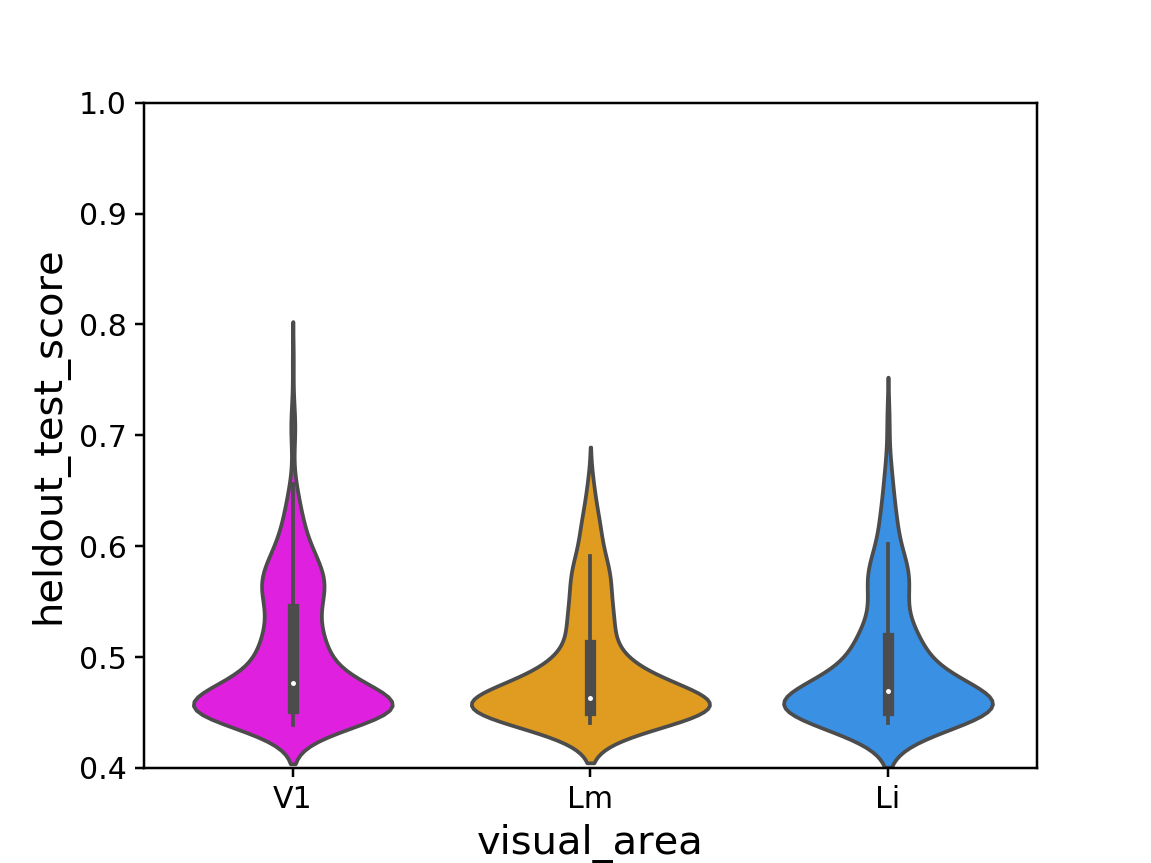

C                     None
fit_time              None
heldout_MI            None
heldout_aMI           None
heldout_log2MI        None
heldout_test_score    None
n_cells               None
n_trials              None
score_time            None
test_score            None
train_score           None
cell                  None
datakey               None
visual_area           None
dtype: object

In [27]:
metric='heldout_test_score'
xdf = singledf[singledf['datakey'].isin(curr_dkeys)]
xdf_n = xdf.copy()
xdf_n.apply(pd.to_numeric, errors='coerce').fillna(xdf_n)
xdf_n.head()


fig, ax = pl.subplots()
# sns.barplot(x='visual_area', y=metric, data=xdf, 
#            facecolor='w', edgecolor=('k', 'k', 'k'), order=visual_areas, ax=ax)
# sns.stripplot(x='visual_area', y=metric, data=xdf, ax=ax,
#              palette=area_colors,  order=visual_areas,)

sns.violinplot(x='visual_area',  y=metric, data=xdf, ax=ax,
             palette=area_colors,  order=visual_areas)

ax.set_ylim([0.4, 1])

xdf_n.apply(aggr.annotateBars, ax=ax, fontsize=12, fontcolor='k', xytext=(0, -40))


<IPython.core.display.Javascript object>


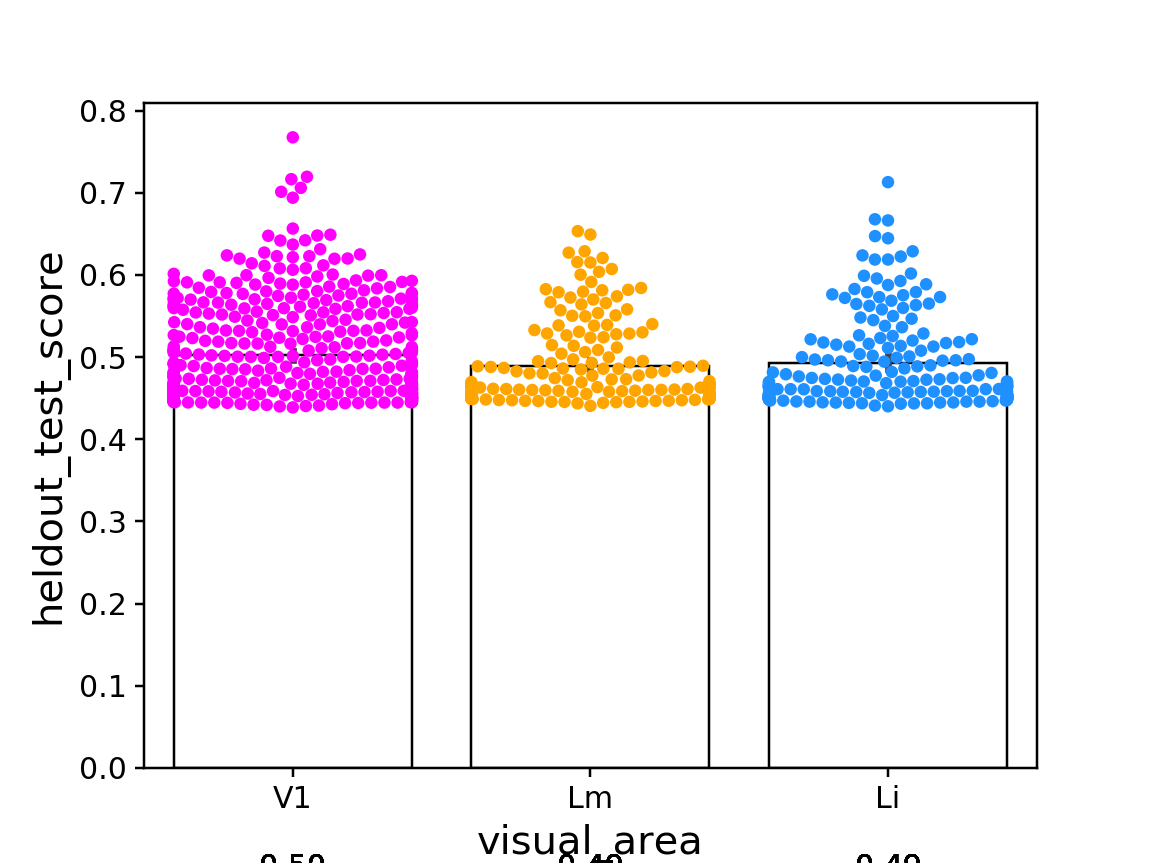

C                     None
fit_time              None
heldout_MI            None
heldout_aMI           None
heldout_log2MI        None
heldout_test_score    None
n_cells               None
n_trials              None
score_time            None
test_score            None
train_score           None
cell                  None
datakey               None
visual_area           None
dtype: object

In [37]:
fig, ax = pl.subplots()
sns.barplot(x='visual_area', y=metric, data=xdf, 
           facecolor='w', edgecolor=('k', 'k', 'k'), order=visual_areas, ax=ax)
sns.swarmplot(x='visual_area', y=metric, data=xdf, ax=ax,
             palette=area_colors,  order=visual_areas,)

xdf.apply(aggr.annotateBars, ax=ax, fontsize=12, fontcolor='k', xytext=(0, -40))


In [ ]:
g.head

In [35]:
singledf.groupby(['visual_area']).mean()

,C,fit_time,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,n_cells,n_trials,score_time,test_score,train_score,cell
visual_area,,,,,,,,,,,,
Li,7.337312,0.001127,0.009656,0.006840,0.013930,0.493282,1.0,299.619565,0.000298,0.536930,0.541611,141.119565
Lm,7.421948,0.001123,0.008848,0.005680,0.012765,0.488769,1.0,296.011236,0.000319,0.533930,0.538750,116.831461
V1,7.833727,0.001170,0.011666,0.009097,0.016831,0.505262,1.0,304.589235,0.000300,0.544101,0.548646,148.310198


<IPython.core.display.Javascript object>


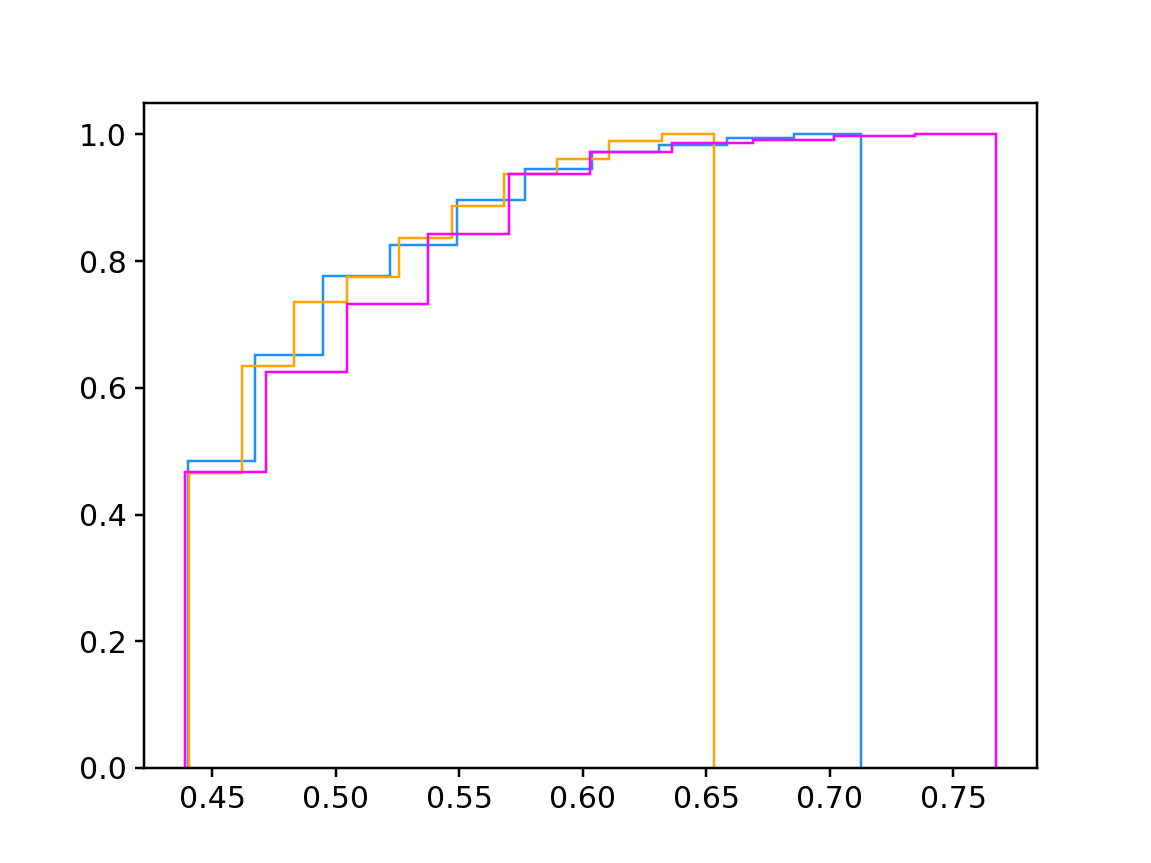

In [36]:
metric='heldout_test_score'
fig, ax = pl.subplots()
# for visual_area, vdf in singledf.groupby(['visual_area']):
#     sns.distplot(vdf[metric].values, color=area_colors[visual_area], ax=ax, kde=False, #bins=100,
#                 hist_kws={"histtype": "step", "linewidth": 3})

xdf = singledf[singledf['datakey'].isin(curr_dkeys)]
for visual_area, vdf in xdf.groupby(['visual_area']):
    n, bins, patches = ax.hist(vdf[metric].values, color=area_colors[visual_area],
                                density=True, histtype='step', cumulative=True)
    
    
